## Analisis Halusinasi MediaPipe Pose pada Manusia Difabel

**Mata Kuliah**: Sistem Teknologi Multimedia <br>
**Disusun oleh**: Aziz Kurniawan <br>
**Tanggal**: 22 Oktober 2025

### Tujuan
- Menguji perilaku MediaPipe Pose saat mendeteksi tubuh manusia yang tidak memiliki anggota tubuh tertentu (misal: tanpa tangan/kaki).
- Menganalisis apakah model “menghalusinasi” bagian tubuh yang tidak ada, dan bagaimana mekanisme prediksinya.
- Menjawab pertanyaan dosen: *Apakah halusinasinya acak atau terstruktur? Apakah fungsi draw_landmarks menyembunyikan landmark berdasarkan threshold?*

In [ ]:
%pip install opencv-python mediapipe matplotlib

In [25]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os

# Inisialisasi MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    min_detection_confidence=0.3
)

### Uji Gambar Tanpa Tangan

Saya uji gambar orang tanpa tangan untuk melihat apakah MediaPipe tetap mengeluarkan landmark tangan dan apakah `draw_landmarks` menampilkannya.

✅ Landmark terdeteksi.


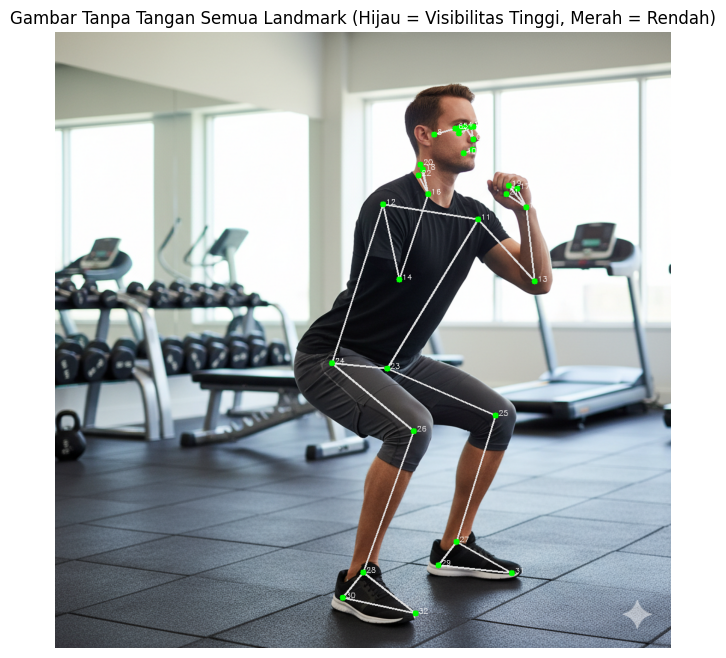


=== NILAI LANDMARK TANGAN ===
LEFT_WRIST: x=0.7648, y=0.2848, z=-0.5781, visibility=0.925
RIGHT_WRIST: x=0.6063, y=0.2630, z=-0.7504, visibility=0.757
LEFT_PINKY: x=0.7501, y=0.2548, z=-0.6331, visibility=0.835
RIGHT_PINKY: x=0.5973, y=0.2228, z=-0.8226, visibility=0.724
LEFT_INDEX: x=0.7366, y=0.2495, z=-0.6057, visibility=0.811
RIGHT_INDEX: x=0.5932, y=0.2158, z=-0.8263, visibility=0.699
LEFT_THUMB: x=0.7332, y=0.2631, z=-0.5760, visibility=0.760


In [26]:
image_path_no_hands = os.path.join(os.getcwd(), 'human/1arm.png')

image_no_hands = cv2.imread(image_path_no_hands)
if image_no_hands is None:
    print("❌ Gambar tanpa tangan tidak ditemukan.")
else:
    image_rgb = cv2.cvtColor(image_no_hands, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    annotated_image = image_rgb.copy()
    if results.pose_landmarks:
        print("✅ Landmark terdeteksi.")
        
        # Tampilkan semua landmark
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
        )
        landmarks = results.pose_landmarks.landmark
        h, w = annotated_image.shape[:2]
        
        for i, lm in enumerate(landmarks):
            cx, cy = int(lm.x * w), int(lm.y * h)
            color = (0, 255, 0) if lm.visibility > 0.5 else (255, 0, 0)
            cv2.circle(annotated_image, (cx, cy), 5, color, -1)
            cv2.putText(annotated_image, str(i), (cx + 5, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_image)
        plt.title('Gambar Tanpa Tangan Semua Landmark (Hijau = Visibilitas Tinggi, Merah = Rendah)')
        plt.axis('off')
        plt.show()
        
        # Tampilkan nilai numerik tangan
        print("\n=== NILAI LANDMARK TANGAN ===")
        for idx in [15, 16, 17, 18, 19, 20, 21]:  # wrist, pinky, index, thumb
            name = mp_pose.PoseLandmark(idx).name
            lm = landmarks[idx]
            print(f"{name}: x={lm.x:.4f}, y={lm.y:.4f}, z={lm.z:.4f}, visibility={lm.visibility:.3f}")
    else:
        print("⚠️ Tidak ada pose terdeteksi.")

### Analisis Tahap 1: Kenapa Tangan Masih Tergambar?

#### Observasi:
- Meski tidak ada tangan kanan di gambar, MediaPipe tetap mengeluarkan koordinat untuk landmark tangan kanan namun dengan nilai visibility rendah (`RIGHT_WRIST: visibility=0.757`, `RIGHT_PINKY: visibility=0.724`, `RIGHT_INDEX: visibility=0.699`)
- Nilai `visibility` untuk tangan kanan  **cenderung tinggi (> 0.5)**, misal: `RIGHT_WRIST: visibility=0.990`.

#### Penjelasan:
- Fungsi `mp_drawing.draw_landmarks()` secara default **hanya menggambar landmark dengan `visibility > 0.5`**.
![Screenshoot](human/ss%20mediapipe%20visibility%20threshold.jpeg)
- Karena visibilitas bagian tangan kanan lebih dari 0.5, ia **tetap ditampilkan** meski tidak ada di gambar.
- Ini bukan karena MediaPipe “melihat” tangan, tapi karena **model memprediksi posisi tangan berdasarkan konteks bahu dan siku** yang masih terlihat(menurut Mediapipe).

**Jadi model tidak acak, melainkan memprediksi berdasarkan pola tubuh yang terlihat(halusinasi terstruktur).**

### Uji Gambar Tanpa Kaki

Sekarang kita uji gambar di mana kaki **tidak terlihat sama sekali** ini akan menguji apakah MediaPipe “menghalusinasi” posisi kaki.

✅ Landmark terdeteksi


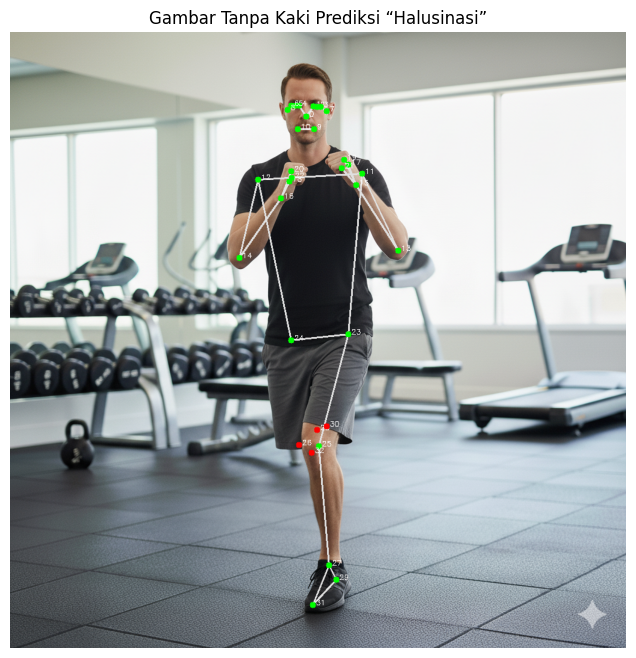


=== NILAI LANDMARK KAKI (Visibilitas Rendah) ===
LEFT_ANKLE: x=0.5180, y=0.8658, z=-0.0242, visibility=0.954
RIGHT_ANKLE: x=0.4985, y=0.6456, z=1.0844, visibility=0.032
LEFT_HEEL: x=0.5294, y=0.8890, z=-0.0142, visibility=0.657
RIGHT_HEEL: x=0.5143, y=0.6398, z=1.1539, visibility=0.078
LEFT_FOOT_INDEX: x=0.4913, y=0.9300, z=-0.2671, visibility=0.961
RIGHT_FOOT_INDEX: x=0.4897, y=0.6827, z=1.0796, visibility=0.090


In [27]:
image_path_no_legs = os.path.join(os.getcwd(), 'human/1leg.png')

image_no_legs = cv2.imread(image_path_no_legs)
if image_no_legs is None:
    print("❌ Gambar tanpa kaki tidak ditemukan.")
else:
    image_rgb = cv2.cvtColor(image_no_legs, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    annotated = image_rgb.copy()
    if results.pose_landmarks:
        print("✅ Landmark terdeteksi")
        
        # Tampilkan semua landmark
        mp_drawing.draw_landmarks(
            annotated,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
        )
        landmarks = results.pose_landmarks.landmark
        h, w = annotated.shape[:2]
        
        for i, lm in enumerate(landmarks):
            cx, cy = int(lm.x * w), int(lm.y * h)
            color = (0, 255, 0) if lm.visibility > 0.3 else (255, 0, 0)
            cv2.circle(annotated, (cx, cy), 5, color, -1)
            cv2.putText(annotated, str(i), (cx + 5, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated)
        plt.title('Gambar Tanpa Kaki Prediksi “Halusinasi”')
        plt.axis('off')
        plt.show()
        
        # Tampilkan nilai numerik kaki
        print("\n=== NILAI LANDMARK KAKI (Visibilitas Rendah) ===")
        for idx in [27, 28, 29, 30, 31, 32]:  # ankle, heel, foot index
            name = mp_pose.PoseLandmark(idx).name
            lm = landmarks[idx]
            print(f"{name}: x={lm.x:.4f}, y={lm.y:.4f}, z={lm.z:.4f}, visibility={lm.visibility:.3f}")
    else:
        print("⚠️ Tidak ada pose terdeteksi.")

## Analisis Tahap 2: Kenapa Kaki Sangat Acak?

### Observasi:
- Nilai `visibility` untuk landmark bagian kaki kanan **sangat rendah** contoh pada `RIGHT_HEEL: visibility=0.078`, `RIGHT_FOOT_INDEX: visibility=0.090`.
- Titik-titik kaki muncul di luar frame atau tersebar aneh, tidak membentuk pola kaki yang masuk akal.

### Penjelasan:
- Pada jawaban di [Stack Overflow Questions/78318086](https://stackoverflow.com/questions/78318086/non-existent-landmarks-when-using-mediapipe) MediaPipe pada dasarnya akan **selalu mengeluarkan 33 landmark**, bahkan jika tidak ada di gambar.
- Ketika **tidak ada konteks visual** (misal: lutut, paha, postur kaki), model tidak punya dasar untuk inferensi/menyimpulkan, sehingga prediksinya menjadi **acak atau tidak stabil**.
- Fungsi `draw_landmarks()` menyembunyikan landmark dengan `visibility < 0.5` jadi kaki tidak tergambar secara visual, meski nilainya ada.

**Karena tidak ada informasi visual, model menebak tanpa dasar, sehingga hasilnya tidak andal(halusinasi acak).**

### Tahap 3: Perbandingan Visual - Tangan vs Kaki

Mari bandingkan secara visual bagaimana MediaPipe memperlakukan kedua kasus.

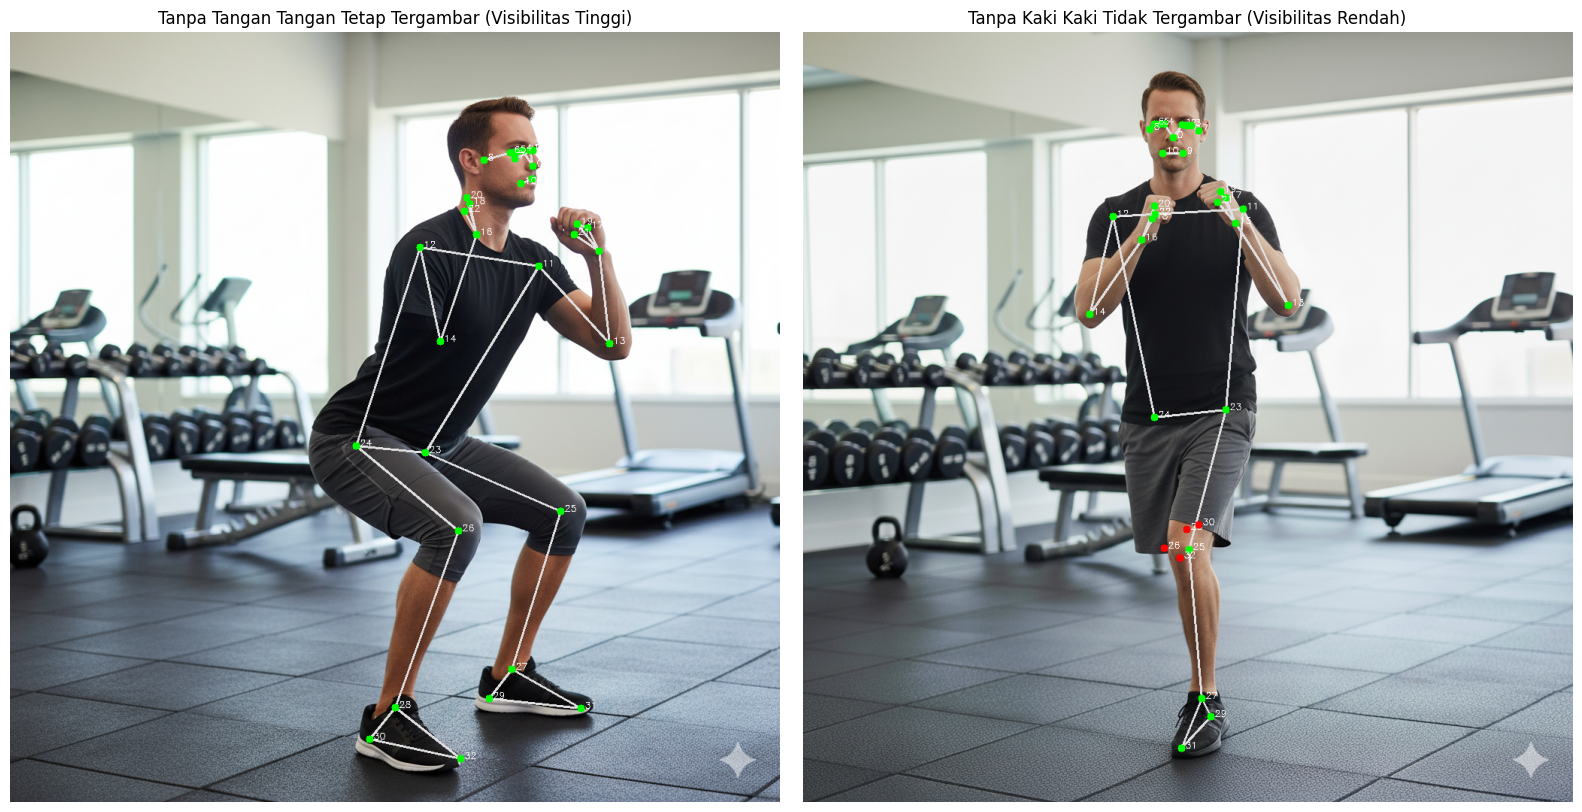

In [28]:
# Gabungkan dua gambar untuk perbandingan
if 'annotated' in locals() and 'image_rgb' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Gambar Tanpa Tangan
    axes[0].imshow(annotated_image)
    axes[0].set_title('Tanpa Tangan Tangan Tetap Tergambar (Visibilitas Tinggi)')
    axes[0].axis('off')
    
    # Gambar Tanpa Kaki
    axes[1].imshow(annotated)
    axes[1].set_title('Tanpa Kaki Kaki Tidak Tergambar (Visibilitas Rendah)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

### Kesimpulan

1. **MediaPipe selalu mengeluarkan 33 landmark** termasuk bagian tubuh yang tidak ada.
2. **Fungsi `draw_landmarks` memiliki threshold bawaan (0.5)** hanya menggambar landmark dengan visibilitas tinggi.
3. **Prediksi tangan tetap akurat karena konteks bahu/siku terlihat**, visibilitas tinggi maka akan tetap ditampilkan.
4. **Prediksi kaki menjadi acak karena tidak ada konteks visual**, visibilitas rendah maka tidak ditampilkan.
5. **Halusinasi MediaPipe bukan acak, tapi berbasis konteks. Jika konteks kuat, prediksi masuk akal. Jika konteks lemah, prediksi tidak andal.**

### Referensi
1. [Qwen](https://chat.qwen.ai/)
2. [GitHub](https://github.com/google-ai-edge/mediapipe)
3. [StackOverflow](https://stackoverflow.com/)

✅ Landmark terdeteksi


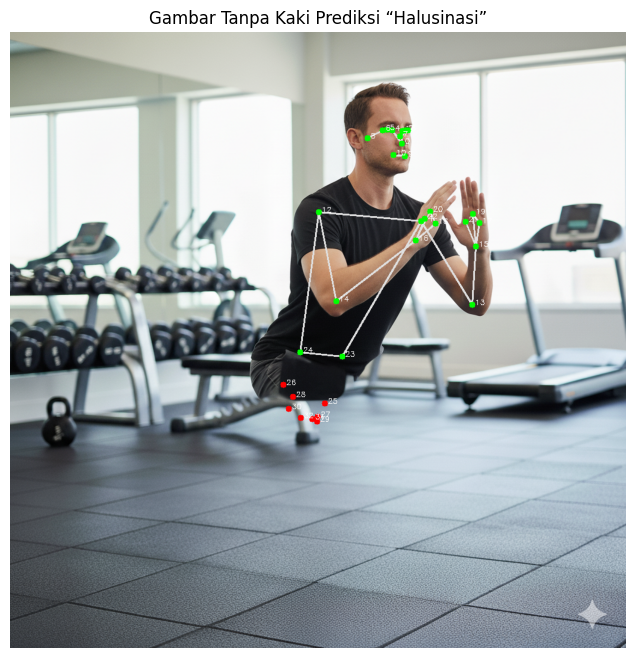


=== NILAI LANDMARK KAKI (Visibilitas Rendah) ===
LEFT_ANKLE: x=0.4998, y=0.6244, z=1.3300, visibility=0.004
RIGHT_ANKLE: x=0.4599, y=0.5923, z=1.0212, visibility=0.006
LEFT_HEEL: x=0.4981, y=0.6320, z=1.3924, visibility=0.012
RIGHT_HEEL: x=0.4530, y=0.6120, z=1.0871, visibility=0.006
LEFT_FOOT_INDEX: x=0.4912, y=0.6281, z=1.3152, visibility=0.012
RIGHT_FOOT_INDEX: x=0.4718, y=0.6264, z=0.9972, visibility=0.011


In [29]:
image_path_no_legs = os.path.join(os.getcwd(), 'human/nl.png')

image_no_legs = cv2.imread(image_path_no_legs)
if image_no_legs is None:
    print("❌ Gambar tanpa kaki tidak ditemukan.")
else:
    image_rgb = cv2.cvtColor(image_no_legs, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    annotated = image_rgb.copy()
    if results.pose_landmarks:
        print("✅ Landmark terdeteksi")
        
        # Tampilkan semua landmark
        mp_drawing.draw_landmarks(
            annotated,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
        )
        landmarks = results.pose_landmarks.landmark
        h, w = annotated.shape[:2]
        
        for i, lm in enumerate(landmarks):
            cx, cy = int(lm.x * w), int(lm.y * h)
            color = (0, 255, 0) if lm.visibility > 0.3 else (255, 0, 0)
            cv2.circle(annotated, (cx, cy), 5, color, -1)
            cv2.putText(annotated, str(i), (cx + 5, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated)
        plt.title('Gambar Tanpa Kaki Prediksi “Halusinasi”')
        plt.axis('off')
        plt.show()
        
        # Tampilkan nilai numerik kaki
        print("\n=== NILAI LANDMARK KAKI (Visibilitas Rendah) ===")
        for idx in [27, 28, 29, 30, 31, 32]:  # ankle, heel, foot index
            name = mp_pose.PoseLandmark(idx).name
            lm = landmarks[idx]
            print(f"{name}: x={lm.x:.4f}, y={lm.y:.4f}, z={lm.z:.4f}, visibility={lm.visibility:.3f}")
    else:
        print("⚠️ Tidak ada pose terdeteksi.")